# Calc stat

In [1]:
subjects = [
    ("tcas", "Node0x11de49030"),
    ("schedule2", "Node0x12e40c1d0-0"),
    ("totinfo", "Node0x12071d8a0"),
    ("printtokens2", "Node0x159a56690"),
    ("replace", "Node0x147e2f150-0"),
    ("gif2png", "Node0x600003241800"),
    ("jsoncpp", "Node0x3f069240"),
    ("jasper", "Node0x1190697d0"),
    ("readelf", "Node0x60000118f680"),
    ("freetype2", "Node0x3cfed20"),
]


In [2]:
import pandas as pd
import numpy as np
import os


def log_err(gt, e):
    return np.abs(np.log10(gt) - np.log10(e))


def rel_err(gt, e):
    return np.abs(gt - e) / gt


def compute_err_table(err_formula):
    stat_data = []
    for prog, node in subjects:
        # Load the data
        result_dir = [
            d
            for d in os.listdir(f"esti-result/{prog}/start4")
            if d.startswith(node)
        ][0]
        result_dir = f"esti-result/{prog}/start4/{result_dir}"

        gt_path = f"{result_dir}/reach_GT.txt"
        with open(gt_path) as f:
            gt = float(f.readlines()[2].strip().split()[-1])
        lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
        gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
        struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")

        pd.options.mode.chained_assignment = None
        np.seterr(divide="ignore")
        if prog not in ["readelf", "freetype2"]:
            max_unit = lap_esti_df["unit"].max()
            sub_lap_esti_df = lap_esti_df[lap_esti_df["unit"] <= max_unit / 10]
            sub_gt_esti_df = gt_esti_df[gt_esti_df["unit"] <= max_unit / 10]
            sub_gt_esti_df[sub_gt_esti_df["esti"] > 1]["re"] = np.inf
            sub_struct_esti_df = struct_esti_df[
                struct_esti_df["unit"] <= max_unit / 10
            ]
        else:
            sub_lap_esti_df = lap_esti_df
            sub_gt_esti_df = gt_esti_df
            sub_gt_esti_df[sub_gt_esti_df["esti"] > 1]["re"] = np.inf
            sub_struct_esti_df = struct_esti_df

        if err_formula == "rel_err":
            sub_lap_esti_df["re"] = rel_err(gt, sub_lap_esti_df["esti"])
            sub_gt_esti_df["re"] = rel_err(gt, sub_gt_esti_df["esti"])
            sub_struct_esti_df["re"] = rel_err(gt, sub_struct_esti_df["esti"])
        elif err_formula == "log_err":
            sub_lap_esti_df["re"] = log_err(gt, sub_lap_esti_df["esti"])
            sub_gt_esti_df["re"] = log_err(gt, sub_gt_esti_df["esti"])
            sub_struct_esti_df["re"] = log_err(gt, sub_struct_esti_df["esti"])
        pd.options.mode.chained_assignment = "warn"
        np.seterr(divide="warn")

        print(f"{prog=}, {node=}")
        print(
            f"{sum(((sub_lap_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int))=}"
        )
        if sum(((sub_lap_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int)) > 0:
            print("idx:", sub_lap_esti_df[(sub_lap_esti_df['re'] - sub_struct_esti_df['re'] <= 0)]["unit"].values, len(sub_struct_esti_df))
        print(
            f"{sum(((sub_gt_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int))=}"
        )
        if sum(((sub_gt_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int)) > 0:
            print("idx:", sub_gt_esti_df[(sub_gt_esti_df['re'] - sub_struct_esti_df['re'] <= 0)]["unit"].values, len(sub_struct_esti_df))

        lap_errs = np.array(sub_lap_esti_df["re"])
        gt_errs = np.array(sub_gt_esti_df["re"])
        struct_errs = np.array(sub_struct_esti_df["re"])
        lap_err_minus_struct_errs = lap_errs - struct_errs
        gt_err_minus_struct_errs = gt_errs - struct_errs

        ten_percent_samples = len(sub_lap_esti_df)
        print(prog, node, ten_percent_samples)
        errs = []
        for r in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]:
            unit_idx = np.floor(ten_percent_samples * r)
            if unit_idx < 1:
                errs.extend(
                    [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
                )
                continue
            assert unit_idx in sub_lap_esti_df["unit"].values
            lap_err = sub_lap_esti_df.loc[
                sub_lap_esti_df["unit"] == unit_idx, "re"
            ].values[0]
            gt_unit_idx = unit_idx
            while True:
                if gt_unit_idx < 1:
                    break
                if gt_unit_idx in sub_gt_esti_df["unit"].values:
                    if not np.isinf(
                        sub_gt_esti_df.loc[
                            sub_gt_esti_df["unit"] == gt_unit_idx, "re"
                        ].values[0]
                    ):
                        break
                gt_unit_idx -= 1
            if gt_unit_idx < 1:
                gt_err = np.nan
            else:
                gt_err = sub_gt_esti_df.loc[
                    sub_gt_esti_df["unit"] == gt_unit_idx, "re"
                ].values[0]
            assert unit_idx in sub_struct_esti_df["unit"].values
            struct_err = sub_struct_esti_df.loc[
                sub_struct_esti_df["unit"] == unit_idx, "re"
            ].values[0]
            lap_err_minus_struct_err = lap_err - struct_err
            gt_err_minus_struct_err = (
                np.nan if np.isnan(gt_err) else gt_err - struct_err
            )
            errs.extend(
                [
                    unit_idx,
                    gt_unit_idx,
                    lap_err,
                    gt_err,
                    struct_err,
                    lap_err_minus_struct_err,
                    gt_err_minus_struct_err,
                ]
            )

        lap_minus_struct_max_error = lap_err_minus_struct_errs.max()
        gt_minus_struct_max_error = gt_err_minus_struct_errs[
            gt_err_minus_struct_errs != np.inf
        ].max()

        stat_data.append(
            (
                prog,
                node,
                gt,
                *errs,
                lap_minus_struct_max_error,
                gt_minus_struct_max_error,
            )
        )

    columns = ["prog", "node", "gt"]
    for r in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]:
        r = r * 10
        columns.extend(
            [
                f"#@{r}",
                f"#\*@{r}",
                f"L@{r}",
                f"G@{r}*",
                f"S@{r}",
                f"L-S@{r}",
                f"G-S@{r}*",
            ]
        )
    columns.extend(["max(L-S)", "max(G-S)*"])
    return pd.DataFrame(
        stat_data,
        columns=columns,
    )


In [3]:
stat_df = compute_err_table("log_err")

prog='tcas', node='Node0x11de49030'
sum(((sub_lap_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int))=0
sum(((sub_gt_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int))=0
tcas Node0x11de49030 186
prog='schedule2', node='Node0x12e40c1d0-0'
sum(((sub_lap_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int))=0
sum(((sub_gt_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int))=19
idx: [ 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106] 250
schedule2 Node0x12e40c1d0-0 250
prog='totinfo', node='Node0x12071d8a0'
sum(((sub_lap_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int))=0
sum(((sub_gt_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int))=0
totinfo Node0x12071d8a0 108
prog='printtokens2', node='Node0x159a56690'
sum(((sub_lap_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int))=12
idx: [ 1  2  3  4  5  6  7  8  9 10 11 12] 12
sum(((sub_gt_esti_df['re'] - sub_struct_esti_df['re'] <= 0)).astype(int))=0
print

In [4]:
mean_df = stat_df.iloc[:, 2:].mean(axis=0)
data = []
for r in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]:
    r = r * 10
    for strat in ["L", "G", "S", "L-S", "G-S"]:
        data.append(
            (
                strat,
                r,
                mean_df[f"{strat}@{r}" + ("*" if "G" in strat else "")],
            )
        )
mean_df = pd.DataFrame(data, columns=["strat", "r", "val"])
mean_df["r"] = mean_df["r"].astype(float)
display(mean_df)

,strat,r,val
0,L,0.1,3.002827
1,G,0.1,4.665882
2,S,0.1,1.774530
3,L-S,0.1,1.228297
4,G-S,0.1,2.891352
5,L,0.2,2.811506
6,G,0.2,3.677782
7,S,0.2,1.813701
8,L-S,0.2,0.997804
9,G-S,0.2,1.864080


[(0.00784313725490196, 0.24313725490196078, 1.0), (1.0, 0.48627450980392156, 0.0), (0.10196078431372549, 0.788235294117647, 0.2196078431372549), (0.9098039215686274, 0.0, 0.043137254901960784), (0.5450980392156862, 0.16862745098039217, 0.8862745098039215), (0.6235294117647059, 0.2823529411764706, 0.0), (0.9450980392156862, 0.2980392156862745, 0.7568627450980392), (0.6392156862745098, 0.6392156862745098, 0.6392156862745098), (1.0, 0.7686274509803922, 0.0), (0.0, 0.8431372549019608, 1.0)]
[(0.00784313725490196, 0.24313725490196078, 1.0), (1.0, 0.48627450980392156, 0.0), (0.10196078431372549, 0.788235294117647, 0.2196078431372549), (0.9098039215686274, 0.0, 0.043137254901960784), (0.5450980392156862, 0.16862745098039217, 0.8862745098039215), (0.6235294117647059, 0.2823529411764706, 0.0), (0.9450980392156862, 0.2980392156862745, 0.7568627450980392), (0.6392156862745098, 0.6392156862745098, 0.6392156862745098), (1.0, 0.7686274509803922, 0.0), (0.0, 0.8431372549019608, 1.0)]
[(0.007843137254

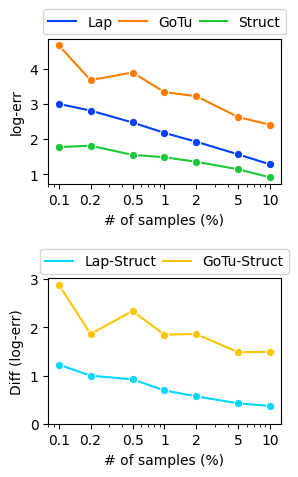

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = list(sns.color_palette("bright"))
print(colors)
print(colors)
sns.set_palette(sns.color_palette(colors))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 5))
sns.lineplot(
    x="r",
    y="val",
    hue="strat",
    data=mean_df.loc[mean_df["strat"].isin(["L", "G", "S"])],
    ax=ax1,
    marker="o",
)
ax1.set_xlabel("# of samples (%)")
ax1.set_ylabel("log-err")
ax1.legend(
    loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3, columnspacing=0.5
)
new_labels1 = ["Lap", "GoTu", "Struct"]
for t, l in zip(ax1.legend_.texts, new_labels1):
    t.set_text(l)
ax1.set_xscale("log")
ax1.set_xticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
ax1.set_xticklabels(["0.1", "0.2", "0.5", "1", "2", "5", "10"])

colors = list(sns.color_palette("bright"))
print(colors)
colors = colors[::-1]
print(colors)
sns.set_palette(sns.color_palette(colors))
sns.lineplot(
    x="r",
    y="val",
    hue="strat",
    data=mean_df.loc[mean_df["strat"].isin(["L-S", "G-S"])],
    ax=ax2,
    marker="o",
)
ax2.set_ylim(0, ax2.get_ylim()[1])
ax2.set_xlabel("# of samples (%)")
ax2.set_ylabel("Diff (log-err)")
ax2.legend(title="Diff")
ax2.legend(
    loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3, columnspacing=0.5
)
new_labels2 = ["Lap-Struct", "GoTu-Struct"]
for t, l in zip(ax2.legend_.texts, new_labels2):
    t.set_text(l)
ax2.set_xscale("log")
ax2.set_xticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
ax2.set_xticklabels(["0.1", "0.2", "0.5", "1", "2", "5", "10"])

fig.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.65)
fig.savefig("figures/avg-log-err2.pdf", bbox_inches="tight")

plt.show()


### Find the last number of samples whose error is larger than second order of magnitude difference

In [7]:
def compute_index():
    stat_data = []
    data = []
    for prog, node in subjects:
        # Load the data
        result_dir = [
            d
            for d in os.listdir(f"esti-result/{prog}/start4")
            if d.startswith(node)
        ][0]
        result_dir = f"esti-result/{prog}/start4/{result_dir}"

        gt_path = f"{result_dir}/reach_GT.txt"
        with open(gt_path) as f:
            gt = float(f.readlines()[2].strip().split()[-1])
        lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
        gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
        struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")

        pd.options.mode.chained_assignment = None
        np.seterr(divide="ignore")
        if prog not in ["readelf", "freetype2"]:
            max_unit = lap_esti_df["unit"].max()
            sub_lap_esti_df = lap_esti_df[lap_esti_df["unit"] <= max_unit / 10]
            sub_gt_esti_df = gt_esti_df[gt_esti_df["unit"] <= max_unit / 10]
            sub_gt_esti_df[sub_gt_esti_df["esti"] > 1]["re"] = np.inf
            sub_struct_esti_df = struct_esti_df[
                struct_esti_df["unit"] <= max_unit / 10
            ]
        else:
            sub_lap_esti_df = lap_esti_df
            sub_gt_esti_df = gt_esti_df
            sub_gt_esti_df[sub_gt_esti_df["esti"] > 1]["re"] = np.inf
            sub_struct_esti_df = struct_esti_df

        sub_lap_esti_df["re"] = log_err(gt, sub_lap_esti_df["esti"])
        sub_gt_esti_df["re"] = log_err(gt, sub_gt_esti_df["esti"])
        sub_struct_esti_df["re"] = log_err(gt, sub_struct_esti_df["esti"])
        pd.options.mode.chained_assignment = "warn"
        np.seterr(divide="warn")

        num_units = []
        for strat, sub_esti_df in [
            ("Lap", sub_lap_esti_df),
            ("GoTu", sub_gt_esti_df),
            ("Struct", sub_struct_esti_df),
        ]:
            unit_idx = -1
            for row in sub_esti_df.itertuples():
                if not np.isinf(row.re) and row.re > 2:
                    unit_idx = row.unit
            if unit_idx == max(sub_esti_df["unit"]):
                unit_idx = -1
            elif unit_idx == -1:
                unit_idx = 1
            else:
                non_inf_units = sub_esti_df[sub_esti_df["re"] != np.inf]["unit"]
                larger_units = non_inf_units[non_inf_units > unit_idx]
                if len(larger_units) > 0:
                    unit_idx = larger_units.min()
                else:
                    unit_idx = -1
            print(
                f"{strat=} {prog=} {unit_idx=},",
                end=" ",
            )
            if unit_idx > 0:
                print(f"{sub_lap_esti_df.loc[unit_idx, 're']=}")
            else:
                print()
            num_units.append(unit_idx)
        data.append([prog] + num_units)
    stat_df = pd.DataFrame(
        data,
        columns=[
            "prog",
            "Lap",
            "GoTu",
            "Struct",
        ],
    )
    return stat_df


stat_df = compute_index()
display(stat_df)


strat='Lap' prog='tcas' unit_idx=34, sub_lap_esti_df.loc[unit_idx, 're']=1.9798818526157262
strat='GoTu' prog='tcas' unit_idx=134, sub_lap_esti_df.loc[unit_idx, 're']=1.4279316593881284
strat='Struct' prog='tcas' unit_idx=8, sub_lap_esti_df.loc[unit_idx, 're']=2.4570031073353893
strat='Lap' prog='schedule2' unit_idx=47, sub_lap_esti_df.loc[unit_idx, 're']=1.9845651405801954
strat='GoTu' prog='schedule2' unit_idx=88, sub_lap_esti_df.loc[unit_idx, 're']=1.7320855356610596
strat='Struct' prog='schedule2' unit_idx=9, sub_lap_esti_df.loc[unit_idx, 're']=2.554440448536757
strat='Lap' prog='totinfo' unit_idx=18, sub_lap_esti_df.loc[unit_idx, 're']=1.97533212552382
strat='GoTu' prog='totinfo' unit_idx=-1, 
strat='Struct' prog='totinfo' unit_idx=14, sub_lap_esti_df.loc[unit_idx, 're']=2.058306360588584
strat='Lap' prog='printtokens2' unit_idx=1, sub_lap_esti_df.loc[unit_idx, 're']=1.629255400007249
strat='GoTu' prog='printtokens2' unit_idx=-1, 
strat='Struct' prog='printtokens2' unit_idx=1, sub

,prog,Lap,GoTu,Struct
0,tcas,34,134,8
1,schedule2,47,88,9
2,totinfo,18,-1,14
3,printtokens2,1,-1,1
4,replace,70,301,1
5,gif2png,64,170,1
6,jsoncpp,5,-1,1
7,jasper,77,-1,32
8,readelf,100630,-1,100630
9,freetype2,242449,-1,15154


# Draw figure

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np
import os

colors = list(sns.color_palette("bright", 3))
print(colors)
print(colors)
sns.set_palette(sns.color_palette(colors))

[(0.00784313725490196, 0.24313725490196078, 1.0), (1.0, 0.48627450980392156, 0.0), (0.10196078431372549, 0.788235294117647, 0.2196078431372549)]
[(0.00784313725490196, 0.24313725490196078, 1.0), (1.0, 0.48627450980392156, 0.0), (0.10196078431372549, 0.788235294117647, 0.2196078431372549)]


## Tcas

result_dir='fuzz-result/tcas/start4/Node0x11de49030-3.12e-02-4'
max_sub_unit=186
x_ticks=array([  0,  65, 130])


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/3139491203.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_lap_esti_df["tool"] = "Lap"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/3139491203.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_gt_esti_df["tool"] = "GT"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/3139491203.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

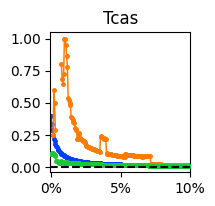

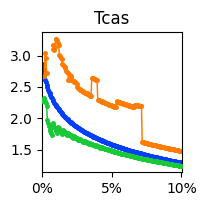

In [9]:
prog, node = subjects[0]
result_dir = [
    d for d in os.listdir(f"esti-result/{prog}/start4") if d.startswith(node)
][0]
result_dir = f"esti-result/{prog}/start4/{result_dir}"
print(f"{result_dir=}")

gt_path = f"{result_dir}/reach_GT.txt"
with open(gt_path) as f:
    gt = float(f.readlines()[2].strip().split()[-1])
lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")
max_unit = lap_esti_df["unit"].max()
sub_lap_esti_df = lap_esti_df[lap_esti_df["unit"] <= max_unit / 10]
sub_gt_esti_df = gt_esti_df[gt_esti_df["unit"] <= max_unit / 10]
sub_struct_esti_df = struct_esti_df[struct_esti_df["unit"] <= max_unit / 10]

sub_lap_esti_df["tool"] = "Lap"
sub_gt_esti_df["tool"] = "GT"
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["re"] != np.inf]
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["esti"] <= 1]
sub_struct_esti_df["tool"] = "Struct"
sub_esti_df = pd.concat(
    (
        sub_lap_esti_df,
        sub_gt_esti_df,
        sub_struct_esti_df[["unit", "esti", "re", "tool"]],
    )
)
sub_esti_df["rel-log-err"] = sub_esti_df["re"]
sub_esti_df["log-err"] = log_err(gt, sub_esti_df["esti"])
sub_esti_df["rel-err"] = rel_err(gt, sub_esti_df["esti"])

max_sub_unit = sub_esti_df["unit"].max()
if max_sub_unit > 3:
    print(f"{max_sub_unit=}")
    unit = 5
    while max_sub_unit / unit > 3:
        unit += 5
    x_ticks = np.arange(0, max_sub_unit + 1, unit)
    print(f"{x_ticks=}")


f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
ax = sns.pointplot(
    x="unit",
    y="esti",
    hue="tool",
    data=sub_esti_df,
    scale=0.4,
    ax=ax,
)
ax.legend(loc=(1.025, 0.5), title="Method")
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
len_ticks = len(ax.get_xticks())
ax.xaxis.set_major_locator(
    ticker.FixedLocator(
        [
            0,
            np.floor(len_ticks / 2),
            len_ticks - 1,
        ]
    )
)
ax.set_xticklabels(["0%", "5%", "10%"])
ax.axhline(gt, color="black", linestyle="--", zorder=10)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Tcas")
ax.get_legend().remove()
f.savefig("figures/Tcas-esti.pdf", bbox_inches="tight")
plt.show()

for err_type in ["log-err"]:
    f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
    ax = sns.pointplot(
        x="unit", y=err_type, hue="tool", data=sub_esti_df, scale=0.4, ax=ax
    )
    ax.legend(loc=(1.025, 0.5), title="Method")
    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
    len_ticks = len(ax.get_xticks())
    ax.xaxis.set_major_locator(
        ticker.FixedLocator(
            [
                0,
                np.floor(len_ticks / 2),
                len_ticks - 1,
            ]
        )
    )
    ax.set_xticklabels(["0%", "5%", "10%"])
    ax.set_title("Tcas")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Tcas")
    ax.get_legend().remove()
    f.savefig(f"figures/Tcas-{err_type}.pdf", bbox_inches="tight")
    plt.show()



## Schedule2

result_dir='fuzz-result/schedule2/start4/Node0x12e40c1d0-0-6.25e-02-3'
max_sub_unit=250
x_ticks=array([  0,  85, 170])


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/545283701.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_lap_esti_df["tool"] = "Lap"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/545283701.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_gt_esti_df["tool"] = "GT"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/545283701.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

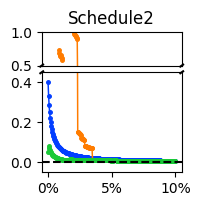

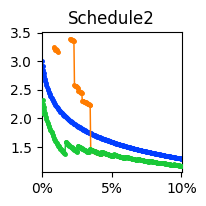

In [10]:
prog, node = subjects[1]
result_dir = [
    d for d in os.listdir(f"esti-result/{prog}/start4") if d.startswith(node)
][0]
result_dir = f"esti-result/{prog}/start4/{result_dir}"
print(f"{result_dir=}")

gt_path = f"{result_dir}/reach_GT.txt"
with open(gt_path) as f:
    gt = float(f.readlines()[2].strip().split()[-1])
lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")
max_unit = lap_esti_df["unit"].max()
sub_lap_esti_df = lap_esti_df[lap_esti_df["unit"] <= max_unit / 10]
sub_gt_esti_df = gt_esti_df[gt_esti_df["unit"] <= max_unit / 10]
sub_struct_esti_df = struct_esti_df[struct_esti_df["unit"] <= max_unit / 10]

sub_lap_esti_df["tool"] = "Lap"
sub_gt_esti_df["tool"] = "GT"
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["re"] != np.inf]
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["esti"] <= 1]
sub_struct_esti_df["tool"] = "Struct"
sub_esti_df = pd.concat(
    (
        sub_lap_esti_df,
        sub_gt_esti_df,
        sub_struct_esti_df[["unit", "esti", "re", "tool"]],
    )
)
sub_esti_df["rel-log-err"] = sub_esti_df["re"]
sub_esti_df["log-err"] = log_err(gt, sub_esti_df["esti"])
sub_esti_df["rel-err"] = rel_err(gt, sub_esti_df["esti"])

max_sub_unit = sub_esti_df["unit"].max()
if max_sub_unit > 3:
    print(f"{max_sub_unit=}")
    unit = 5
    while max_sub_unit / unit > 3:
        unit += 5
    x_ticks = np.arange(0, max_sub_unit + 1, unit)
    print(f"{x_ticks=}")

f, (ax1, ax2) = plt.subplots(
    ncols=1, nrows=2, sharex=True, gridspec_kw={"height_ratios": [1, 3]}, figsize=(2, 2)
)
ax1 = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax1
)
ax2 = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax2
)
ax1.set_ylim(0.5, 1)
ax2.set_ylim(-0.05, 0.45)
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("")
ax2.set_ylabel("")
ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
plt.subplots_adjust(hspace=0.1)
d = 0.01
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((-d, +d), (-3 * d, +3 * d), **kwargs)
ax1.plot((1 - d, 1 + d), (-3 * d, +3 * d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
ax1.set_title("Schedule2")
ax2.set_xlabel("")
len_ticks = len(ax2.get_xticks())
ax2.xaxis.set_major_locator(
    ticker.FixedLocator(
        [
            0,
            np.floor(len_ticks / 2),
            len_ticks - 1,
        ]
    )
)
ax2.set_xticklabels(["0%", "5%", "10%"])
ax2.axhline(gt, color="black", linestyle="--", zorder=10)
f.savefig("figures/Schedule2-esti.pdf", bbox_inches="tight")
plt.show()

for err_type in ["log-err"]:
    f, ax = plt.subplots(
        ncols=1, nrows=1, figsize=(2, 2), 
    )
    ax = sns.pointplot(
        x="unit", y=err_type, hue="tool", data=sub_esti_df, scale=0.4, ax=ax
    )
    ax.get_legend().remove()
    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
    len_ticks = len(ax.get_xticks())
    ax.xaxis.set_major_locator(
        ticker.FixedLocator(
            [
                0,
                np.floor(len_ticks / 2),
                len_ticks - 1,
            ]
        )
    )
    ax.set_xticklabels(["0%", "5%", "10%"])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Schedule2")
    f.savefig(f"figures/Schedule2-{err_type}.pdf", bbox_inches="tight")
    plt.show()


## Totinfo

result_dir='fuzz-result/totinfo/start4/Node0x12071d8a0-1.56e-02-5'
max_sub_unit=108
x_ticks=array([ 0, 40, 80])


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/4259081071.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_lap_esti_df["tool"] = "Lap"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/4259081071.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_gt_esti_df["tool"] = "GT"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/4259081071.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

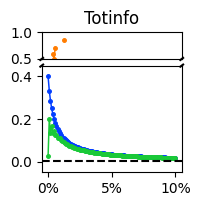

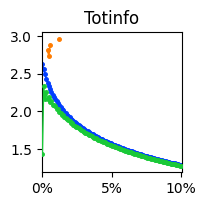

In [11]:
prog, node = subjects[2]
result_dir = [
    d for d in os.listdir(f"esti-result/{prog}/start4") if d.startswith(node)
][0]
result_dir = f"esti-result/{prog}/start4/{result_dir}"
print(f"{result_dir=}")

gt_path = f"{result_dir}/reach_GT.txt"
with open(gt_path) as f:
    gt = float(f.readlines()[2].strip().split()[-1])
lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")
max_unit = lap_esti_df["unit"].max()
sub_lap_esti_df = lap_esti_df[lap_esti_df["unit"] <= max_unit / 10]
sub_gt_esti_df = gt_esti_df[gt_esti_df["unit"] <= max_unit / 10]
sub_struct_esti_df = struct_esti_df[struct_esti_df["unit"] <= max_unit / 10]

sub_lap_esti_df["tool"] = "Lap"
sub_gt_esti_df["tool"] = "GT"
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["re"] != np.inf]
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["esti"] <= 1]
sub_struct_esti_df["tool"] = "Struct"
sub_esti_df = pd.concat(
    (
        sub_lap_esti_df,
        sub_gt_esti_df,
        sub_struct_esti_df[["unit", "esti", "re", "tool"]],
    )
)
sub_esti_df["rel-log-err"] = sub_esti_df["re"]
sub_esti_df["log-err"] = log_err(gt, sub_esti_df["esti"])
sub_esti_df["rel-err"] = rel_err(gt, sub_esti_df["esti"])


max_sub_unit = sub_esti_df["unit"].max()
if max_sub_unit > 3:
    print(f"{max_sub_unit=}")
    unit = 5
    while max_sub_unit / unit > 3:
        unit += 5
    x_ticks = np.arange(0, max_sub_unit + 1, unit)
    print(f"{x_ticks=}")

f, (ax1, ax2) = plt.subplots(
    ncols=1, nrows=2, sharex=True, gridspec_kw={"height_ratios": [1, 4]}, figsize=(2, 2)
)
ax1 = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax1
)
ax2 = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax2
)
ax1.set_ylim(0.5, 1)
ax2.set_ylim(-0.05, 0.45)
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("")
ax2.set_ylabel("")
ax2.set_xlabel("")

ax1.get_legend().remove()
ax2.get_legend().remove()

ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
plt.subplots_adjust(hspace=0.1)
d = 0.01  
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((-d, +d), (-4 * d, +4 * d), **kwargs)  
ax1.plot((1 - d, 1 + d), (-4 * d, +4 * d), **kwargs)  
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  
ax1.set_title("Totinfo")




len_ticks = len(ax2.get_xticks())
ax2.xaxis.set_major_locator(
    ticker.FixedLocator(
        [
            0,
            np.floor(len_ticks / 2),
            len_ticks - 1,
        ]
    )
)
ax2.set_xticklabels(["0%", "5%", "10%"])
ax2.axhline(gt, color="black", linestyle="--", zorder=10)
f.savefig("figures/Totinfo-esti.pdf", bbox_inches="tight")
plt.show()



for err_type in ["log-err"]:
    f, ax = plt.subplots(
        ncols=1, nrows=1, figsize=(2, 2)
    )
    ax = sns.pointplot(
        x="unit", y=err_type, hue="tool", data=sub_esti_df, scale=0.4, ax=ax
    )
    ax.get_legend().remove()
    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.xaxis.set_major_locator(
        ticker.FixedLocator(
            [
                0,
                np.floor(len_ticks / 2),
                len_ticks - 1,
            ]
        )
    )
    ax.set_xticklabels(["0%", "5%", "10%"])
    ax.set_title("Totinfo")
    f.savefig(f"figures/Totinfo-{err_type}.pdf", bbox_inches="tight")
    plt.show()


## Printtokens2

result_dir='fuzz-result/printtokens2/start4/Node0x159a56690-3.52e-02-6'
max_sub_unit=12
x_ticks=array([ 0,  4,  8, 12])


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/95883017.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_lap_esti_df["tool"] = "Lap"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/95883017.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_gt_esti_df["tool"] = "GT"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/95883017.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

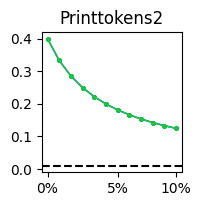

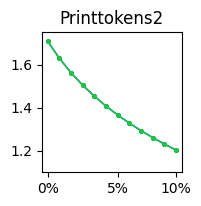

In [12]:
prog, node = subjects[3]
result_dir = [
    d for d in os.listdir(f"esti-result/{prog}/start4") if d.startswith(node)
][0]
result_dir = f"esti-result/{prog}/start4/{result_dir}"
print(f"{result_dir=}")

gt_path = f"{result_dir}/reach_GT.txt"
with open(gt_path) as f:
    gt = float(f.readlines()[2].strip().split()[-1])
lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")
max_unit = lap_esti_df["unit"].max()
sub_lap_esti_df = lap_esti_df[lap_esti_df["unit"] <= max_unit / 10]
sub_gt_esti_df = gt_esti_df[gt_esti_df["unit"] <= max_unit / 10]
sub_struct_esti_df = struct_esti_df[struct_esti_df["unit"] <= max_unit / 10]

sub_lap_esti_df["tool"] = "Lap"
sub_gt_esti_df["tool"] = "GT"
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["re"] != np.inf]
sub_struct_esti_df["tool"] = "Struct"
sub_esti_df = pd.concat(
    (
        sub_lap_esti_df,
        sub_gt_esti_df,
        sub_struct_esti_df[["unit", "esti", "re", "tool"]],
    )
)
sub_esti_df["rel-log-err"] = sub_esti_df["re"]
sub_esti_df["log-err"] = log_err(gt, sub_esti_df["esti"])
sub_esti_df["rel-err"] = rel_err(gt, sub_esti_df["esti"])

max_sub_unit = sub_esti_df["unit"].max()
if max_sub_unit > 3:
    print(f"{max_sub_unit=}")
    unit = 1
    while max_sub_unit / unit > 3:
        unit += 1
    x_ticks = np.arange(0, max_sub_unit + 1, unit)
    print(f"{x_ticks=}")

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
ax = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax
)
ax.legend().remove()
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Printtokens2")
len_ticks = len(ax.get_xticks())
ax.xaxis.set_major_locator(
    ticker.FixedLocator(
        [
            0,
            np.floor(len_ticks / 2),
            len_ticks - 1,
        ]
    )
)
ax.set_xticklabels(["0%", "5%", "10%"])
ax.axhline(gt, color="black", linestyle="--", zorder=10)
ax.set_ylim(-0.01, 0.42)
f.savefig("figures/Printtokens2-esti.pdf", bbox_inches="tight")
plt.show()

for err_type in ["log-err"]:
    f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
    ax = sns.pointplot(
        x="unit", y=err_type, hue="tool", data=sub_esti_df, scale=0.4, ax=ax
    )
    ax.legend().remove()
    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Printtokens2")
    ax.xaxis.set_major_locator(
        ticker.FixedLocator(
            [
                0,
                np.floor(len_ticks / 2),
                len_ticks - 1,
            ]
        )
    )
    ax.set_xticklabels(["0%", "5%", "10%"])
    if err_type == "rel-log-err":
        ax.set_ylim(0.23, 0.85)
    elif err_type == "log-err":
        ax.set_ylim(1.1, 1.75)
    else:
        ax.set_ylim(1, 55)
    f.savefig(f"figures/Printtokens2-{err_type}.pdf", bbox_inches="tight")
    plt.show()


## Replace

result_dir='fuzz-result/replace/start4/Node0x147e2f150-0-1.72e-05-18'
max_sub_unit=365
x_ticks=array([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
       325, 350])


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/543268065.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_lap_esti_df["tool"] = "Lap"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/543268065.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_gt_esti_df["tool"] = "GT"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/543268065.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

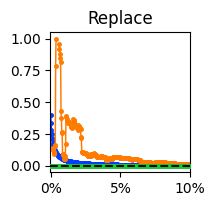

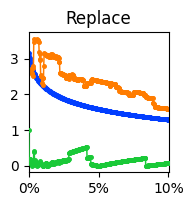

In [13]:
prog, node = subjects[4]
result_dir = [
    d for d in os.listdir(f"esti-result/{prog}/start4") if d.startswith(node)
][0]
result_dir = f"esti-result/{prog}/start4/{result_dir}"
print(f"{result_dir=}")

gt_path = f"{result_dir}/reach_GT.txt"
with open(gt_path) as f:
    gt = float(f.readlines()[2].strip().split()[-1])
lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")
max_unit = lap_esti_df["unit"].max()
sub_lap_esti_df = lap_esti_df[lap_esti_df["unit"] <= max_unit / 10]
sub_gt_esti_df = gt_esti_df[gt_esti_df["unit"] <= max_unit / 10]
sub_struct_esti_df = struct_esti_df[struct_esti_df["unit"] <= max_unit / 10]

sub_lap_esti_df["tool"] = "Lap"
sub_gt_esti_df["tool"] = "GT"
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["re"] != np.inf]
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["esti"] <= 1]
sub_struct_esti_df["tool"] = "Struct"
sub_esti_df = pd.concat(
    (
        sub_lap_esti_df,
        sub_gt_esti_df,
        sub_struct_esti_df[["unit", "esti", "re", "tool"]],
    )
)
sub_esti_df["rel-log-err"] = sub_esti_df["re"]
sub_esti_df["log-err"] = log_err(gt, sub_esti_df["esti"])
sub_esti_df["rel-err"] = rel_err(gt, sub_esti_df["esti"])

max_sub_unit = sub_esti_df["unit"].max()
if max_sub_unit > 15:
    print(f"{max_sub_unit=}")
    unit = 5
    while max_sub_unit / unit > 15:
        unit += 5
    x_ticks = np.arange(0, max_sub_unit + 1, unit)
    print(f"{x_ticks=}")

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
ax = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax
)
ax.legend(loc=(1.025, 0.5), title="Method").remove()
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Replace")
len_ticks = len(ax.get_xticks())
ax.xaxis.set_major_locator(
    ticker.FixedLocator(
        [
            0,
            np.floor(len_ticks / 2),
            len_ticks - 1,
        ]
    )
)
ax.set_xticklabels(["0%", "5%", "10%"])
ax.axhline(gt, color="black", linestyle="--", zorder=10)
f.savefig("figures/Replace-esti.pdf", bbox_inches="tight")
plt.show()

for err_type in ["log-err"]:
    f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
    ax = sns.pointplot(
        x="unit", y=err_type, hue="tool", data=sub_esti_df, scale=0.4, ax=ax
    )
    ax.legend(loc=(1.025, 0.5), title="Method").remove()
    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Replace")
    len_ticks = len(ax.get_xticks())
    ax.xaxis.set_major_locator(
        ticker.FixedLocator(
            [
                0,
                np.floor(len_ticks / 2),
                len_ticks - 1,
            ]
        )
    )
    ax.set_xticklabels(["0%", "5%", "10%"])
    f.savefig(f"figures/Replace-{err_type}.pdf", bbox_inches="tight")
    plt.show()


## Gif2png

result_dir='fuzz-result/gif2png/start4/Node0x600003241800-3.05e-05-13'
max_sub_unit=338
x_ticks=array([  0, 115, 230])


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/723064269.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_lap_esti_df["tool"] = "Lap"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/723064269.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_gt_esti_df["tool"] = "GT"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/723064269.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

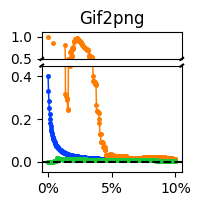

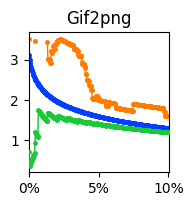

In [14]:
prog, node = subjects[5]
result_dir = [
    d for d in os.listdir(f"esti-result/{prog}/start4") if d.startswith(node)
][0]
result_dir = f"esti-result/{prog}/start4/{result_dir}"
print(f"{result_dir=}")

gt_path = f"{result_dir}/reach_GT.txt"
with open(gt_path) as f:
    gt = float(f.readlines()[2].strip().split()[-1])
lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")
max_unit = lap_esti_df["unit"].max()
sub_lap_esti_df = lap_esti_df[lap_esti_df["unit"] <= max_unit / 10]
sub_gt_esti_df = gt_esti_df[gt_esti_df["unit"] <= max_unit / 10]
sub_struct_esti_df = struct_esti_df[struct_esti_df["unit"] <= max_unit / 10]

sub_lap_esti_df["tool"] = "Lap"
sub_gt_esti_df["tool"] = "GT"
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["re"] != np.inf]
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["esti"] <= 1]
sub_struct_esti_df["tool"] = "Struct"
sub_esti_df = pd.concat(
    (
        sub_lap_esti_df,
        sub_gt_esti_df,
        sub_struct_esti_df[["unit", "esti", "re", "tool"]],
    )
)
sub_esti_df["rel-log-err"] = sub_esti_df["re"]
sub_esti_df["log-err"] = log_err(gt, sub_esti_df["esti"])
sub_esti_df["rel-err"] = rel_err(gt, sub_esti_df["esti"])

max_sub_unit = sub_esti_df["unit"].max()
if max_sub_unit > 3:
    print(f"{max_sub_unit=}")
    unit = 5
    while max_sub_unit / unit > 3:
        unit += 5
    x_ticks = np.arange(0, max_sub_unit + 1, unit)
    print(f"{x_ticks=}")

f, (ax1, ax2) = plt.subplots(
    ncols=1, nrows=2, sharex=True, gridspec_kw={"height_ratios": [1, 4]}, figsize=(2,2)
)
ax1 = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax1
)
ax2 = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax2
)
ax1.set_ylim(0.5, 1.1)
ax2.set_ylim(-0.05, 0.45)
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("")
ax2.set_ylabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
plt.subplots_adjust(hspace=0.1)
d = 0.01
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((-d, +d), (-4 * d, +4 * d), **kwargs)
ax1.plot((1 - d, 1 + d), (-4 * d, +4 * d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
ax1.set_title("Gif2png")
len_ticks = len(ax2.get_xticks())
ax2.xaxis.set_major_locator(
    ticker.FixedLocator(
        [
            0,
            np.floor(len_ticks / 2),
            len_ticks - 1,
        ]
    )
)
ax2.set_xticklabels(["0%", "5%", "10%"])
ax2.axhline(gt, color="black", linestyle="--", zorder=10)
f.savefig("figures/Gif2png-esti.pdf", bbox_inches="tight")
plt.show()

# Err graph
for err_type in ["log-err"]:
    f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2,2))
    ax = sns.pointplot(
        x="unit", y=err_type, hue="tool", data=sub_esti_df, scale=0.4, ax=ax
    )
    ax.legend(loc=(1.025, 0.5), title="Method").remove()
    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Gif2png")
    len_ticks = len(ax.get_xticks())
    ax.xaxis.set_major_locator(
        ticker.FixedLocator(
            [
                0,
                np.floor(len_ticks / 2),
                len_ticks - 1,
            ]
        )
    )
    ax.set_xticklabels(["0%", "5%", "10%"])
    f.savefig(f"figures/Gif2png-{err_type}.pdf", bbox_inches="tight")
    plt.show()


## Jsoncpp

result_dir='fuzz-result/jsoncpp/start4/Node0x3f069240-7.81e-04-8'
max_sub_unit=43
x_ticks=array([ 0, 15, 30])


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/3799112573.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_lap_esti_df["tool"] = "Lap"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/3799112573.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_gt_esti_df["tool"] = "GT"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/3799112573.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

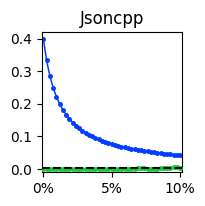

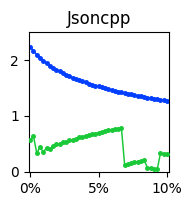

In [15]:
prog, node = subjects[6]
result_dir = [
    d for d in os.listdir(f"esti-result/{prog}/start4") if d.startswith(node)
][0]
result_dir = f"esti-result/{prog}/start4/{result_dir}"
print(f"{result_dir=}")

gt_path = f"{result_dir}/reach_GT.txt"
with open(gt_path) as f:
    gt = float(f.readlines()[2].strip().split()[-1])
lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")
max_unit = lap_esti_df["unit"].max()
sub_lap_esti_df = lap_esti_df[lap_esti_df["unit"] <= max_unit / 10]
sub_gt_esti_df = gt_esti_df[gt_esti_df["unit"] <= max_unit / 10]
sub_struct_esti_df = struct_esti_df[struct_esti_df["unit"] <= max_unit / 10]

sub_lap_esti_df["tool"] = "Lap"
sub_gt_esti_df["tool"] = "GT"
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["re"] != np.inf]
sub_struct_esti_df["tool"] = "Struct"
sub_esti_df = pd.concat(
    (
        sub_lap_esti_df,
        sub_gt_esti_df,
        sub_struct_esti_df[["unit", "esti", "re", "tool"]],
    )
)
sub_esti_df["rel-log-err"] = sub_esti_df["re"]
sub_esti_df["log-err"] = log_err(gt, sub_esti_df["esti"])
sub_esti_df["rel-err"] = rel_err(gt, sub_esti_df["esti"])

max_sub_unit = sub_esti_df["unit"].max()
if max_sub_unit > 3:
    print(f"{max_sub_unit=}")
    unit = 5
    while max_sub_unit / unit > 3:
        unit += 5
    x_ticks = np.arange(0, max_sub_unit + 1, unit)
    print(f"{x_ticks=}")

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2,2))
ax = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax
)
ax.legend(loc=(1.025, 0.5), title="Method").remove()
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Jsoncpp")
len_ticks = len(ax.get_xticks())
ax.xaxis.set_major_locator(
    ticker.FixedLocator(
        [
            0,
            np.floor(len_ticks / 2),
            len_ticks - 1,
        ]
    )
)
ax.set_xticklabels(["0%", "5%", "10%"])
ax.axhline(gt, color="black", linestyle="--", zorder=10)
ax.set_ylim(-0.01, 0.42)
f.savefig("figures/Jsoncpp-esti.pdf", bbox_inches="tight")
plt.show()

for err_type in ["log-err"]:
    f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2,2))
    ax = sns.pointplot(
        x="unit", y=err_type, hue="tool", data=sub_esti_df, scale=0.4, ax=ax
    )
    ax.legend(loc=(1.025, 0.5), title="Method").remove()
    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Jsoncpp")
    len_ticks = len(ax.get_xticks())
    ax.xaxis.set_major_locator(
        ticker.FixedLocator(
            [
                0,
                np.floor(len_ticks / 2),
                len_ticks - 1,
            ]
        )
    )
    ax.set_xticklabels(["0%", "5%", "10%"])
    if err_type == "rel-log-err":
        ax.set_ylim(-0.01, 0.9)
    elif err_type == "log-err":
        ax.set_ylim(-0.01, 2.5)
    else:
        ax.set_ylim(-0.01, 180)
    f.savefig(f"figures/Jsoncpp-{err_type}.pdf", bbox_inches="tight")
    plt.show()


## Jasper

result_dir='fuzz-result/jasper/start4/Node0x1190697d0-7.81e-03-6'
max_sub_unit=403
x_ticks=array([  0, 135, 270])


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/3363783772.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_lap_esti_df["tool"] = "Lap"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/3363783772.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_gt_esti_df["tool"] = "GT"
/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85153/3363783772.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

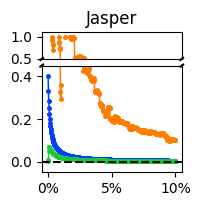

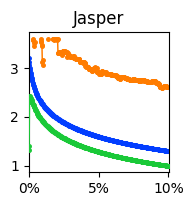

In [16]:
prog, node = subjects[7]
result_dir = [
    d for d in os.listdir(f"esti-result/{prog}/start4") if d.startswith(node)
][0]
result_dir = f"esti-result/{prog}/start4/{result_dir}"
print(f"{result_dir=}")

gt_path = f"{result_dir}/reach_GT.txt"
with open(gt_path) as f:
    gt = float(f.readlines()[2].strip().split()[-1])
lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")
max_unit = lap_esti_df["unit"].max()
sub_lap_esti_df = lap_esti_df[lap_esti_df["unit"] <= max_unit / 10]
sub_gt_esti_df = gt_esti_df[gt_esti_df["unit"] <= max_unit / 10]
sub_struct_esti_df = struct_esti_df[struct_esti_df["unit"] <= max_unit / 10]

sub_lap_esti_df["tool"] = "Lap"
sub_gt_esti_df["tool"] = "GT"
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["re"] != np.inf]
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["esti"] <= 1]
sub_struct_esti_df["tool"] = "Struct"
sub_esti_df = pd.concat(
    (
        sub_lap_esti_df,
        sub_gt_esti_df,
        sub_struct_esti_df[["unit", "esti", "re", "tool"]],
    )
)
sub_esti_df["rel-log-err"] = sub_esti_df["re"]
sub_esti_df["log-err"] = log_err(gt, sub_esti_df["esti"])
sub_esti_df["rel-err"] = rel_err(gt, sub_esti_df["esti"])

max_sub_unit = sub_esti_df["unit"].max()
if max_sub_unit > 3:
    print(f"{max_sub_unit=}")
    unit = 5
    while max_sub_unit / unit > 3:
        unit += 5
    x_ticks = np.arange(0, max_sub_unit + 1, unit)
    print(f"{x_ticks=}")

f, (ax1, ax2) = plt.subplots(
    ncols=1, nrows=2, sharex=True, gridspec_kw={"height_ratios": [1, 4]}, figsize=(2,2)
)
ax1 = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax1
)
ax2 = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax2
)
ax1.set_ylim(0.5, 1.1)
ax2.set_ylim(-0.05, 0.45)
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("")
ax2.set_ylabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")

ax1.get_legend().remove()
ax2.get_legend().remove()

ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
plt.subplots_adjust(hspace=0.1)
d = 0.01
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((-d, +d), (-4 * d, +4 * d), **kwargs)
ax1.plot((1 - d, 1 + d), (-4 * d, +4 * d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
ax1.set_title("Jasper")
len_ticks = len(ax2.get_xticks())
ax2.xaxis.set_major_locator(
    ticker.FixedLocator(
        [
            0,
            np.floor(len_ticks / 2),
            len_ticks - 1,
        ]
    )
)
ax2.set_xticklabels(["0%", "5%", "10%"])
ax2.axhline(gt, color="black", linestyle="--", zorder=10)
f.savefig("figures/Jasper-esti.pdf", bbox_inches="tight")
plt.show()

for err_type in ["log-err"]:
    f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2,2))
    ax = sns.pointplot(
        x="unit", y=err_type, hue="tool", data=sub_esti_df, scale=0.4, ax=ax
    )
    ax.legend(loc=(1.025, 0.5), title="Method").remove()
    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Jasper")
    len_ticks = len(ax.get_xticks())
    ax.xaxis.set_major_locator(
        ticker.FixedLocator(
            [
                0,
                np.floor(len_ticks / 2),
                len_ticks - 1,
            ]
        )
    )
    ax.set_xticklabels(["0%", "5%", "10%"])
    f.savefig(f"figures/Jasper-{err_type}.pdf", bbox_inches="tight")
    plt.show()


## Readelf

result_dir='fuzz-result/readelf/start4/Node0x60000118f680-3.74e-04-13'


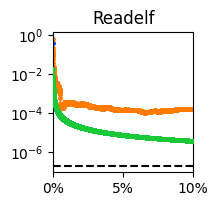

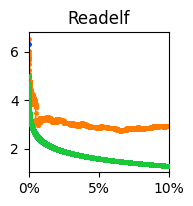

In [18]:
import matplotlib.ticker as ticker

prog, node = subjects[8]
result_dir = [
    d for d in os.listdir(f"esti-result/{prog}/start4") if d.startswith(node)
][0]
result_dir = f"esti-result/{prog}/start4/{result_dir}"
print(f"{result_dir=}")

gt_path = f"{result_dir}/reach_GT.txt"
with open(gt_path) as f:
    gt = float(f.readlines()[2].strip().split()[-1])
lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")
max_unit = lap_esti_df["unit"].max()
sub_lap_esti_df = lap_esti_df
sub_gt_esti_df = gt_esti_df
sub_struct_esti_df = struct_esti_df

sub_lap_esti_df["tool"] = "Lap"
sub_gt_esti_df["tool"] = "GT"
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["re"] != np.inf]
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["esti"] <= 1]
sub_struct_esti_df["tool"] = "Struct"
sub_esti_df = pd.concat(
    (
        sub_lap_esti_df,
        sub_gt_esti_df,
        sub_struct_esti_df[["unit", "esti", "re", "tool"]],
    )
)
sub_esti_df["rel-log-err"] = sub_esti_df["re"]
sub_esti_df["log-err"] = log_err(gt, sub_esti_df["esti"])
sub_esti_df["rel-err"] = rel_err(gt, sub_esti_df["esti"])

sub_units = list(range(1, sub_esti_df.unit.max() + 1, 100))
sub_esti_df = sub_esti_df.loc[sub_esti_df["unit"].isin(sub_units)]

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
ax = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax
)
xticklabels = ax.get_xticklabels()
newticklabels = [
    f"{round(int(label.get_text()) / 100000, 1):,}e+5" for label in xticklabels
]
ax.set_xticklabels(newticklabels)
ax.legend(loc=(1.025, 0.5), title="Method").remove()
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Readelf")
ax.set_yscale("log")
len_ticks = len(ax.get_xticks())
ax.xaxis.set_major_locator(
    ticker.FixedLocator(
        [
            0,
            np.floor(len_ticks / 2),
            len_ticks - 1,
        ]
    )
)
ax.set_xticklabels(["0%", "5%", "10%"])
ax.axhline(gt, color="black", linestyle="--", zorder=10)
f.savefig("figures/Readelf-esti.pdf", bbox_inches="tight")
plt.show()

for err_type in ["log-err"]:
    f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
    ax = sns.pointplot(
        x="unit", y=err_type, hue="tool", data=sub_esti_df, scale=0.4, ax=ax
    )
    xticklabels = ax.get_xticklabels()
    newticklabels = [
        f"{round(int(label.get_text()) / 100000, 1):,}e+5"
        for label in xticklabels
    ]
    ax.set_xticklabels(newticklabels)
    ax.legend(loc=(1.025, 0.5), title="Method").remove()
    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Readelf")
    len_ticks = len(ax.get_xticks())
    ax.xaxis.set_major_locator(
        ticker.FixedLocator(
            [
                0,
                np.floor(len_ticks / 2),
                len_ticks - 1,
            ]
        )
    )
    ax.set_xticklabels(["0%", "5%", "10%"])
    f.savefig(f"figures/Readelf-{err_type}.pdf", bbox_inches="tight")
    plt.show()


## Freetype2

result_dir='fuzz-result/freetype2/start4/Node0x3cfed20-6.63e-06-35'


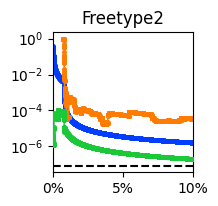

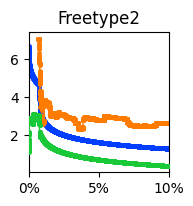

In [17]:
prog, node = subjects[9]
result_dir = [
    d for d in os.listdir(f"esti-result/{prog}/start4") if d.startswith(node)
][0]
result_dir = f"esti-result/{prog}/start4/{result_dir}"

gt_path = f"{result_dir}/reach_GT.txt"
with open(gt_path) as f:
    gt = float(f.readlines()[2].strip().split()[-1])
lap_esti_df = pd.read_csv(f"{result_dir}/reach_lap_esti_df.csv")
gt_esti_df = pd.read_csv(f"{result_dir}/reach_gt_esti_df.csv")
struct_esti_df = pd.read_csv(f"{result_dir}/reach_struct_esti_df.csv")
max_unit = lap_esti_df["unit"].max()
sub_lap_esti_df = lap_esti_df
sub_gt_esti_df = gt_esti_df
sub_struct_esti_df = struct_esti_df

sub_lap_esti_df["tool"] = "Lap"
sub_gt_esti_df["tool"] = "GT"
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["re"] != np.inf]
sub_gt_esti_df = sub_gt_esti_df.loc[sub_gt_esti_df["esti"] <= 1]
sub_struct_esti_df["tool"] = "Struct"
sub_esti_df = pd.concat(
    (
        sub_lap_esti_df,
        sub_gt_esti_df,
        sub_struct_esti_df[["unit", "esti", "re", "tool"]],
    )
)
sub_esti_df["rel-log-err"] = sub_esti_df["re"]
sub_esti_df["log-err"] = log_err(gt, sub_esti_df["esti"])
sub_esti_df["rel-err"] = rel_err(gt, sub_esti_df["esti"])

sub_units = list(range(1, 501)) + list(
    range(501, sub_esti_df.unit.max() + 1, 200)
)
sub_esti_df = sub_esti_df.loc[sub_esti_df["unit"].isin(sub_units)]

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
ax = sns.pointplot(
    x="unit", y="esti", hue="tool", data=sub_esti_df, scale=0.4, ax=ax
)
xticklabels = ax.get_xticklabels()
newticklabels = [
    f"{round(int(label.get_text()) / 100000, 1):,}e+5" for label in xticklabels
]
ax.set_xticklabels(newticklabels)
ax.legend(loc=(1.025, 0.5), title="Method").remove()
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Freetype2")
ax.set_yscale("log")
len_ticks = len(ax.get_xticks())
ax.xaxis.set_major_locator(
    ticker.FixedLocator(
        [
            0,
            np.floor(len_ticks / 2),
            len_ticks - 1,
        ]
    )
)
ax.set_xticklabels(["0%", "5%", "10%"])
ax.axhline(gt, color="black", linestyle="--", zorder=10)
f.savefig("figures/Freetype2-esti.pdf", bbox_inches="tight")
plt.show()

for err_type in ["log-err"]:
    f, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
    ax = sns.pointplot(
        x="unit", y=err_type, hue="tool", data=sub_esti_df, scale=0.4, ax=ax
    )
    xticklabels = ax.get_xticklabels()
    newticklabels = [
        f"{round(int(label.get_text()) / 100000, 1):,}e+5"
        for label in xticklabels
    ]
    ax.set_xticklabels(newticklabels)
    ax.legend(loc=(1.025, 0.5), title="Method").remove()
    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Freetype2")
    len_ticks = len(ax.get_xticks())
    ax.xaxis.set_major_locator(
        ticker.FixedLocator(
            [
                0,
                np.floor(len_ticks / 2),
                len_ticks - 1,
            ]
        )
    )
    ax.set_xticklabels(["0%", "5%", "10%"])
    f.savefig(f"figures/Freetype2-{err_type}.pdf", bbox_inches="tight")
    plt.show()
